# Vehicle Speed Check
### Complete # TODO

# Requirements

In [31]:
import cv2
import dlib
import time
import math
import os

# Loading Model

In [32]:
# Define the path to the Haar Cascade model file using os.path.join for cross-platform compatibility
MODEL_ADDRESS = os.path.join("models", "myhaar.xml")

# Define the path to the video file using os.path.join for cross-platform compatibility
VIDEO_ADDRESS = os.path.join("videos", "cars.mp4")

# Load the Haar Cascade model for car detection
carCascade = cv2.CascadeClassifier(MODEL_ADDRESS)

# Initialize video capture with the specified video file path
video = cv2.VideoCapture(VIDEO_ADDRESS)

# Constants for video frame dimensions
WIDTH = 1280  # Width of the video frame
HEIGHT = 720  # Height of the video frame

# Speed Detection

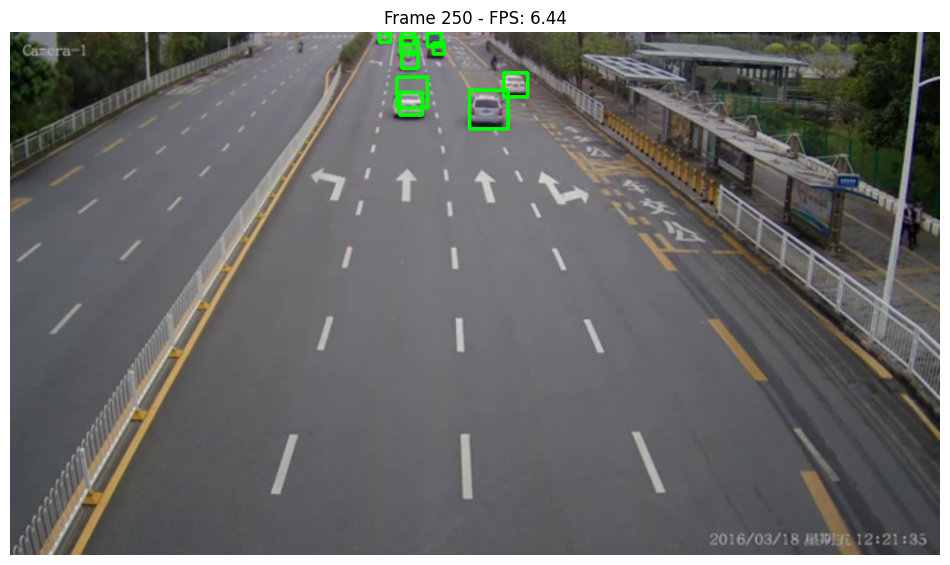

Processing completed. MP4 output saved to output_cars.mp4


In [33]:
from IPython.display import display, clear_output

import matplotlib.pyplot as plt

# Function to estimate the speed of an object based on two locations
def estimateSpeed(location1, location2):
    d_pixels = math.sqrt(
        math.pow(location2[0] - location1[0], 2)
        + math.pow(location2[1] - location1[1], 2)
    )
    ppm = 8.8  # Pixels per meter
    d_meters = d_pixels / ppm  # Distance in meters
    fps = 18  # Frames per second
    speed = d_meters * fps * 3.6  # Speed in km/hr
    return speed

# Function to track multiple objects and save output in MP4 format
def trackMultipleObjectsMP4():
    rectangleColor = (0, 255, 0)
    frameCounter = 0
    currentCarID = 0
    fps = 0

    carTracker = {}
    carLocation1 = {}
    carLocation2 = {}
    speed = [None] * 1000

    # Save output in MP4 format
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter("output_cars.mp4", fourcc, 10, (WIDTH, HEIGHT))

    plt.figure(figsize=(12, 8))
    
    while True:
        start_time = time.time()
        rc, image = video.read()
        if type(image) == type(None):
            break

        image = cv2.resize(image, (WIDTH, HEIGHT))
        resultImage = image.copy()
        frameCounter = frameCounter + 1

        carIDtoDelete = []

        # Update trackers
        for carID in carTracker.keys():
            trackingQuality = carTracker[carID].update(image)
            if trackingQuality < 7:
                carIDtoDelete.append(carID)

        # Remove poor quality trackers
        for carID in carIDtoDelete:
            carTracker.pop(carID, None)
            carLocation1.pop(carID, None)
            carLocation2.pop(carID, None)

        # Detect new cars every 10 frames
        if not (frameCounter % 10):
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            cars = carCascade.detectMultiScale(gray, 1.1, 13, 18, (24, 24))
            for _x, _y, _w, _h in cars:
                x, y, w, h = int(_x), int(_y), int(_w), int(_h)
                x_bar = x + 0.5 * w
                y_bar = y + 0.5 * h
                matchCarID = None

                for carID in carTracker.keys():
                    trackedPosition = carTracker[carID].get_position()
                    t_x = int(trackedPosition.left())
                    t_y = int(trackedPosition.top())
                    t_w = int(trackedPosition.width())
                    t_h = int(trackedPosition.height())
                    t_x_bar = t_x + 0.5 * t_w
                    t_y_bar = t_y + 0.5 * t_h
                    
                    if ((t_x <= x_bar <= (t_x + t_w)) and (t_y <= y_bar <= (t_y + t_h)) and
                        (x <= t_x_bar <= (x + w)) and (y <= t_y_bar <= (y + h))):
                        matchCarID = carID

                if matchCarID is None:
                    tracker = dlib.correlation_tracker()
                    tracker.start_track(image, dlib.rectangle(x, y, x + w, y + h))
                    carTracker[currentCarID] = tracker
                    carLocation1[currentCarID] = [x, y, w, h]
                    currentCarID = currentCarID + 1

        # Update positions and draw rectangles
        for carID in carTracker.keys():
            trackedPosition = carTracker[carID].get_position()
            t_x = int(trackedPosition.left())
            t_y = int(trackedPosition.top())
            t_w = int(trackedPosition.width())
            t_h = int(trackedPosition.height())
            cv2.rectangle(resultImage, (t_x, t_y), (t_x + t_w, t_y + t_h), rectangleColor, 4)
            carLocation2[carID] = [t_x, t_y, t_w, t_h]

        end_time = time.time()
        if not (end_time == start_time):
            fps = 1.0 / (end_time - start_time)

        # Calculate and display speed
        for i in carLocation1.keys():
            if frameCounter % 1 == 0:
                [x1, y1, w1, h1] = carLocation1[i]
                [x2, y2, w2, h2] = carLocation2[i]
                carLocation1[i] = [x2, y2, w2, h2]
                if [x1, y1, w1, h1] != [x2, y2, w2, h2]:
                    if (speed[i] == None or speed[i] == 0) and y1 >= 275 and y1 <= 285:
                        speed[i] = estimateSpeed([x1, y1, w1, h1], [x2, y2, w2, h2])
                    if speed[i] != None and y1 >= 180:
                        cv2.putText(resultImage, str(int(speed[i])) + " km/hr",
                                  (int(x1 + w1 / 2), int(y1 - 5)),
                                  cv2.FONT_HERSHEY_SIMPLEX, 0.75, (255, 255, 255), 2)

        # Write frame to MP4 output
        out.write(resultImage)
        
        # Display progress every 10 frames
        if frameCounter % 10 == 0:
            clear_output(wait=True)
            resultImage_rgb = cv2.cvtColor(resultImage, cv2.COLOR_BGR2RGB)
            plt.clf()
            plt.imshow(resultImage_rgb)
            plt.title(f"Frame {frameCounter} - FPS: {fps:.2f}")
            plt.axis('off')
            display(plt.gcf())
        
        # Process reasonable number of frames
        if frameCounter > 250:
            break

    out.release()
    plt.close()
    video.set(cv2.CAP_PROP_POS_FRAMES, 0)
    print(f"Processing completed. MP4 output saved to output_cars.mp4")

# Run the function
trackMultipleObjectsMP4()

# Vehicle Speed Detection System

## Project Overview
This project implements a real-time vehicle speed detection system using computer vision techniques. The system tracks multiple vehicles in a video stream and estimates their speed based on their movement between consecutive frames.

## Key Features
- **Multi-vehicle tracking**: Simultaneously tracks multiple cars in the video
- **Speed estimation**: Calculates vehicle speed in km/hr using pixel displacement
- **Real-time processing**: Processes video frames with live display updates
- **Output recording**: Saves processed video with speed annotations in MP4 format
- **Robust tracking**: Uses correlation trackers for maintaining object identity across frames

## Technical Implementation

### Core Technologies
- **OpenCV**: For video processing, object detection, and image manipulation
- **dlib**: For correlation-based object tracking
- **Haar Cascades**: For initial vehicle detection
- **Matplotlib**: For real-time frame visualization in Jupyter environment

### Algorithm Workflow
1. **Vehicle Detection**: Uses Haar Cascade classifier to detect cars every 10 frames
2. **Object Tracking**: Employs dlib correlation trackers to follow detected vehicles
3. **Speed Calculation**: Estimates speed using pixel displacement and calibration factors
4. **Visualization**: Draws bounding boxes and speed labels on detected vehicles
5. **Output Generation**: Saves annotated video frames to MP4 file

### Speed Calculation Method
- **Pixel Distance**: Calculates Euclidean distance between vehicle positions in consecutive frames
- **Calibration**: Uses 8.8 pixels per meter conversion factor
- **Frame Rate**: Assumes 18 FPS for time calculation
- **Speed Formula**: `Speed (km/hr) = (distance_meters × fps × 3.6)`

### Performance Optimizations
- **Selective Detection**: Only runs detection every 10 frames to improve performance
- **Quality Tracking**: Removes poor quality trackers (quality < 7) to maintain accuracy
- **ROI Processing**: Speed calculation triggered only in specific Y-coordinate ranges (275-285 pixels)
- **Frame Limiting**: Processes up to 250 frames for demonstration purposes

### Output Specifications
- **Video Resolution**: 1280×720 pixels
- **Output Format**: MP4 with mp4v codec
- **Frame Rate**: 10 FPS for output video
- **Annotations**: Speed displayed in white text above each tracked vehicle
